# Transfer Learning 

## Classification Problem - Emergency vs Non-emergency Vehicle Classification

Table of Contents
1. Import neccessary libraries
2. Load the data
3. Preprocess the data
4. Load weights of pre-trained model
5. Fine tune the model for the current problem
6. Get predictions

## 1. Import neccessary libraries

Here we will import the required libraries and functions.

In [1]:
import numpy as np

In [2]:
np.__version__

'1.21.5'

In [3]:
# import necessary libraries for plotting images
import numpy as np
import matplotlib.pyplot as plt
# plot in jupyter notebook itself
#%matplotlib inline
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
#from skimage.transform import resize

from keras.utils import to_categorical
#used to preprocess data according to VGG16
from keras.applications.vgg16 import preprocess_input
#for instantiating the model and loading the weights and biases
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, InputLayer

Using TensorFlow backend.
c:\Users\divyansh\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\divyansh\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\divyansh\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\divyansh\anaconda3\envs\te

## 2. Load the data

In [4]:
#reading the csv file containing data labels
data = pd.read_csv('Dataset/emergency_classification.csv')

In [5]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [6]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [7]:
# create an empty python list
X = []

# go through all the image locations one by one
for img_name in data.image_names:
    # read the image from location
    img = plt.imread('Dataset/images/' + img_name)
    # pile it one over the other
    X.append(img)
    
# convert this python list to a single numpy array
X = np.array(X)

In [8]:
#getting the labels for images
y = data.emergency_or_not.values

In [9]:
#converting label to categorical i.e instead of 0/1 labels we have 2 columns emergency and non-emergency ,
#with only one of them is true for every image
y = to_categorical(y)

In [10]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## 3. Pre-Process Data

Steps : 
1. Pre-process the data as per model's requirement
2. Prepare training and validation set

In [11]:
#show maximum and minimum values for the image array
X.min(), X.max()

(0, 255)

In [12]:
#preprocess input images accordiing to requirements of VGG16 model
X = preprocess_input(X, mode='tf')

In [13]:
#print minimum and maximum values present in the array
X.min(), X.max()

(-1.0, 1.0)

In [14]:
# splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## 4. Load weights of pretrained model

In [15]:
# creating model with pre trained imagenet weights
base_model = VGG16(weights='imagenet')


553467904/553467096 [==============================] - 260s 0us/step


In [16]:
#shows model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# creating a VGG16 model with imagenet pretrained weights , accepting input of shape (224,224,3)
# also remove the final layers from model(include_top= False)
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

58892288/58889256 [==============================] - 46s 1us/step


In [18]:
# show model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 5. Fine tune the model for the current problem
Steps:-
1. Extract features
2. Flatten the data
3. Rescale features
4. Create a Neural Network Model
5. Compile the model
6. Train and Validate the model

In [19]:
# extract features using the pretrained VGG16 model
# for training set
base_model_pred = base_model.predict(X_train)
#for validation set
base_model_pred_valid = base_model.predict(X_valid)

In [20]:
#show shape of predictions
base_model_pred.shape

(1646, 7, 7, 512)

In [21]:
import skimage
from skimage.transform import resize

In [22]:
# flattening the model output to one dimension for every sample of training set
base_model_pred = base_model_pred.reshape(1646, 7*7*512)

In [23]:
base_model_pred.shape

(1646, 25088)

In [24]:
base_model_pred_valid.shape

(706, 7, 7, 512)

In [25]:
# flattening the model output to one dimension for every sample of validation set
base_model_pred_valid = base_model_pred_valid.reshape(706, 7*7*512)

In [26]:
base_model_pred_valid.shape

(706, 25088)

In [27]:
# checking the min and max of the extracted features
base_model_pred.min(), base_model_pred.max()

(0.0, 11.343674)

In [28]:
#get maximum value from generated features
max_val = base_model_pred.max()

In [29]:
#normalizing features generated from the VGG16 model to [0,1]
base_model_pred = base_model_pred / max_val
base_model_pred_valid = base_model_pred_valid / max_val
base_model_pred.min(), base_model_pred.max()

(0.0, 1.0)

In [30]:
#create a sequential model 
model = Sequential()
# add input layer to the model that accepts input of shape 7*7*512
model.add(InputLayer((7*7*512, )))
# add fully connected layer with 1024 neurons and relu activation
model.add(Dense(units=1024, activation='relu'))
# add fully connected layer with 2 neurons and relu activation
model.add(Dense(units=2, activation='softmax'))

In [31]:
# compile the model
model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 25,693,186
Trainable params: 25,693,186
Non-trainable params: 0
_________________________________________________________________


In [33]:
# model checkpointing
from keras.callbacks import ModelCheckpoint
# defining model checkpointing

# defining the path to store the weights
filepath="best_weights.hdf5"

# defining the model checkpointing and metric to monitor
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# defining checkpointing variable
callbacks_list = [checkpoint]


# train model using features generated from VGG16 model
model_history = model.fit(base_model_pred, y_train, epochs=100, validation_data=(base_model_pred_valid, y_valid), callbacks=callbacks_list)

Train on 1646 samples, validate on 706 samples
Epoch 1/100
1646/1646 [==============================] - 7s 4ms/step - loss: 0.6390 - accuracy: 0.6094 - val_loss: 0.6174 - val_accuracy: 0.5878

Epoch 00001: val_accuracy improved from -inf to 0.58782, saving model to best_weights.hdf5
Epoch 2/100
1646/1646 [==============================] - 6s 4ms/step - loss: 0.5629 - accuracy: 0.7655 - val_loss: 0.5453 - val_accuracy: 0.7890

Epoch 00002: val_accuracy improved from 0.58782 to 0.78895, saving model to best_weights.hdf5
Epoch 3/100
1646/1646 [==============================] - 7s 4ms/step - loss: 0.5040 - accuracy: 0.8117 - val_loss: 0.4971 - val_accuracy: 0.8229

Epoch 00003: val_accuracy improved from 0.78895 to 0.82295, saving model to best_weights.hdf5
Epoch 4/100
1646/1646 [==============================] - 7s 4ms/step - loss: 0.4529 - accuracy: 0.8414 - val_loss: 0.4553 - val_accuracy: 0.8272

Epoch 00004: val_accuracy improved from 0.82295 to 0.82720, saving model to best_weights.h

## 6. Get Predictions

In [100]:
# get predictions
predictions = model.predict_classes(base_model_pred_valid)
#show predictions
predictions.shape

(706,)

In [101]:
predictions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,

## 7. Check Results

In [102]:
predictions = (model.predict(base_model_pred) > 0.5).astype("int32")
print('Accuracy on training set:', accuracy_score(y_train, predictions))

Accuracy on training set: 0.996962332928311


In [103]:
predictions = (model.predict(base_model_pred_valid) > 0.5).astype("int32")
print('Accuracy on test set:', accuracy_score(y_valid, predictions))

Accuracy on test set: 0.9390934844192634


In [104]:
model_history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

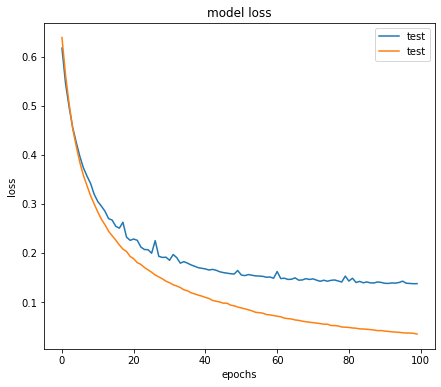

In [105]:
plt.figure(figsize=(7,6))
plt.plot(model_history.history["val_loss"], label="test")
plt.plot(model_history.history["loss"], label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("model loss")
plt.legend()

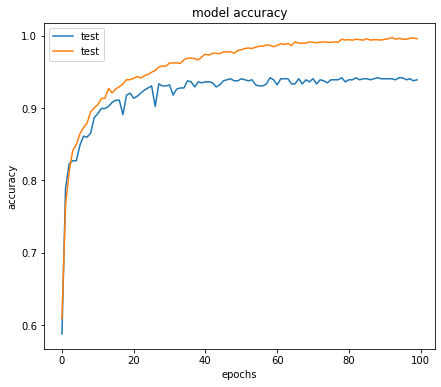

In [106]:
plt.figure(figsize=(7,6))
plt.plot(model_history.history["val_accuracy"], label="test")
plt.plot(model_history.history["accuracy"], label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("model accuracy")
plt.legend()